In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
import json
import math
import datetime
from sqlalchemy.ext.declarative import declarative_base
from scipy import integrate

In [2]:
FIGSIZE = (40, 20)
FONTSIZE = 20

PRODUCTION_COLOR = "mediumspringgreen"
CONSUMPTION_COLOR = "coral"
NET_COLOR = "grey"

with open("../local-database.json", "r") as f:
	config = json.load(f)



# Load solar data from files.

Example:

	FILES = [ "../local-solardata.csv", "../local-solardata-2022-05-12.csv" ]

	solardf = None

	for f in FILES:


		df = pd.read_csv(f,
						header=None,
						names=['datetime', 'consumption', 'production'],
						index_col=0,
						parse_dates=[0])
		if solardf is not None:
			solardf = solardf.append(df)
		else:
			solardf = df

	solardf.sort_index(inplace=True)
		

# Load solar production data from a database

In [3]:
connectionstr = f"mysql+pymysql://{config['solardb_user']}:{config['solardb_pass']}@{config['solardb_host']}/{config['solardb_name']}?charset=utf8mb4"
engine = sqlalchemy.create_engine(connectionstr)
engine.connect()

In [4]:

def beginningOfDay(dt):
	return dt.replace(hour=0, minute=0, second=0, microsecond=0)

def endOfDay(dt):
	return beginningOfDay(dt) + datetime.timedelta(1)


In [5]:
data_to = endOfDay(datetime.datetime.now())
data_from = data_to - datetime.timedelta(days=7)
data_from_str = data_from.strftime("%Y-%m-%d")
data_to_str = data_to.strftime("%Y-%m-%d")
#data_from_str = '2022-05-18'
#data_to_str = '2022-05-19'

#solardf = pd.read_sql_table('production', engine)
sql =  f'''
SELECT datetime, consumption, production FROM production 
	WHERE datetime >= '{data_from_str}' and datetime < '{data_to_str}'
	ORDER by datetime asc
'''
solardf = pd.read_sql(sql, engine, index_col='datetime')

# Resample data
We may wish to resample data.  Reasons to do this maybe
 * To fill gaps with reasonable values
 * Decrease the number of data points for faster processing
  
`resample()` will resample at our chosen time interval.  Where there is no data, the value is NaN.  There are a couple options
for handling NaN:

 * `dropna()`: will drop these cells.  If graphing, the effect is a gap
 * `fillna()`: will fill these cells with a value.  But what?
 * `bfill()` or `ffill()`: fill backwards from the next value or forward from the previous.  If the gap is small, this is reasonable but if the gap is large it is inaccurate.
 * `interpolate()`:  Will interpolate between the values preceeding the gap and followign the gap.  This may produce the best estimate.

Sample Code:

	df_noop = solardf.resample('1Min').mean()
	df_dropna = solardf.resample('1Min').mean().dropna()
	df_fillna = solardf.resample('1Min').mean().fillna(0)
	df_ffill = solardf.resample('1Min').mean().ffill()
	df_interpolate = solardf.resample('1Min').mean().interpolate(method='linear', axis=0)


In [ ]:
solardf.head()


Text(0.5, 1.0, 'Solar Production')

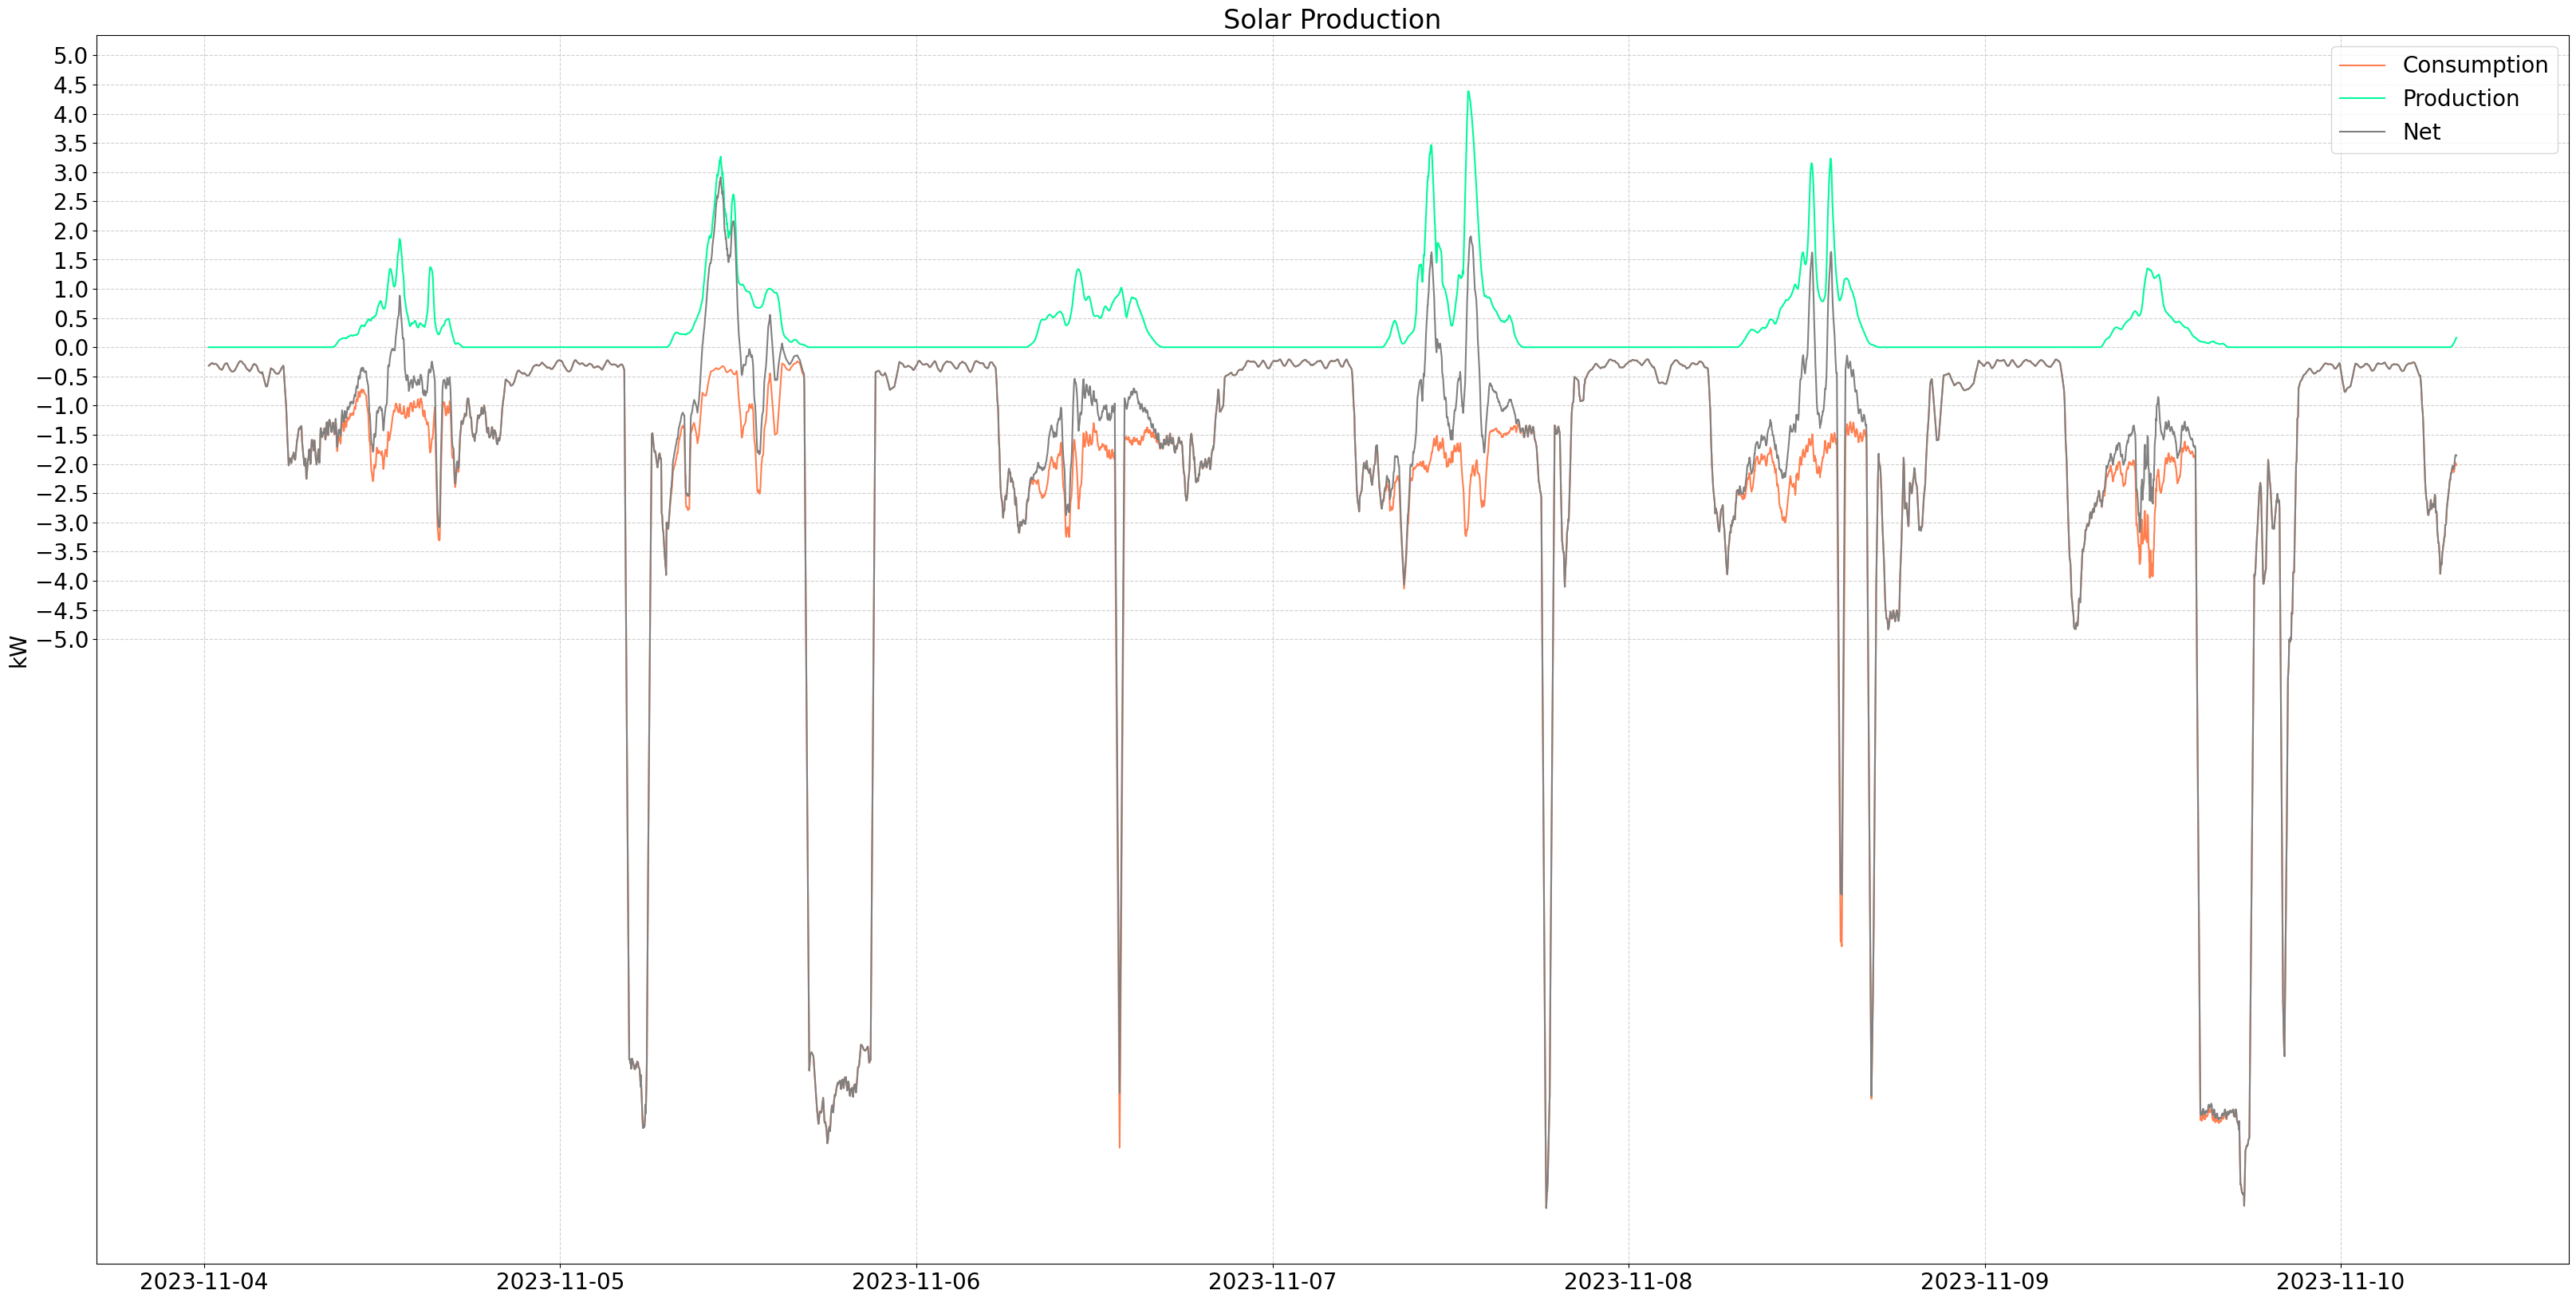

In [6]:
plt.rcParams.update({'font.size': FONTSIZE})
fig = plt.figure(figsize = FIGSIZE)

# Resample and interpolate to fill gaps in data with reasonable value.
df = solardf.resample('1Min').mean().interpolate(method='linear', axis=0)

# Smooth data with rolling average and convert to kiloWatts.
minutes_rolling = 20
smoothed_consumption = -df['consumption'].rolling(minutes_rolling).mean().dropna() / 1000
smoothed_production = df['production'].rolling(minutes_rolling).mean().dropna() / 1000
net = smoothed_production + smoothed_consumption


plt.plot(smoothed_consumption.index, smoothed_consumption, CONSUMPTION_COLOR, label="Consumption")
plt.plot(smoothed_production.index, smoothed_production, PRODUCTION_COLOR, label="Production")
plt.plot(net.index, net, NET_COLOR, label="Net")

# Calculate a max value for the y-axis
max_value = math.ceil(max(-smoothed_consumption.max(), smoothed_production.max()))
step = 0.5
plt.yticks(np.arange(-max_value, max_value+step, step))
plt.ylabel("kW")

plt.grid(alpha =.6, linestyle ='--') 
plt.legend()
plt.title("Solar Production")

# Plot historic production and consumption

In [21]:
# data_to = endOfDay(datetime.datetime.now())
# data_from = data_to - datetime.timedelta(28)
# data_from_str = data_from.strftime("%Y-%m-%d")
# data_to_str = data_to.strftime("%Y-%m-%d")
data_from_str = '2023-06-01'
data_to_str = '2023-07-01'
 
print (f"Plot from {data_from_str} to {data_to_str}")


#solardf = pd.read_sql_table('production', engine)
sql =  f'''
SELECT datetime, consumption, production FROM production 
	WHERE datetime >= '{data_from_str}' and datetime < '{data_to_str}'
	ORDER by datetime asc
'''
intdf = pd.read_sql(sql, engine, index_col='datetime')

Plot from 2023-06-01 to 2023-07-01


In [22]:


# Add back data point time as a column so we can calculate on it.
intdf['datetime'] = intdf.index

# Calculate the cumulative seconds since first data point.
#     	.diff() calculates difference from previous row.
# 		.dt.total_seconds()  reads the value as datetime and gets total seconds
# 		fillna(0) ensures there are no missing data elements.
# 		cumsum() calculates cumulative sum at each row.
intdf['cumsec'] = intdf['datetime'].diff().dt.total_seconds().fillna(0).cumsum()

In [24]:
intdf

,consumption,production,datetime,cumsec
datetime,,,,
2023-06-01 00:00:32.790,905.816,0.0,2023-06-01 00:00:32.790,0.00
2023-06-01 00:01:33.170,841.303,0.0,2023-06-01 00:01:33.170,60.38
2023-06-01 00:02:33.360,840.562,0.0,2023-06-01 00:02:33.360,120.57
2023-06-01 00:03:33.550,838.939,0.0,2023-06-01 00:03:33.550,180.76
2023-06-01 00:04:33.740,597.313,0.0,2023-06-01 00:04:33.740,240.95
...,...,...,...,...
2023-06-30 23:55:11.350,416.714,0.0,2023-06-30 23:55:11.350,2591678.56
2023-06-30 23:56:11.600,399.453,0.0,2023-06-30 23:56:11.600,2591738.81
2023-06-30 23:57:11.850,397.258,0.0,2023-06-30 23:57:11.850,2591799.06


In [25]:
#
# Function to integrate over in groups.
#
def calculate_cumulative(groups, divisor):
	# Arrays to hold values for each column
	cons = []
	prod = []
	index = []

	for name, group in groups:
		#print (group)
		cwh = integrate.trapz(group['consumption'], x=group['cumsec']) / divisor
		pwh = integrate.trapz(group['production'], x=group['cumsec']) / divisor
		cons.append(cwh)
		prod.append(pwh)
		index.append(name)

	return pd.DataFrame({'consumption': cons, 'production': prod}, index=index)


In [26]:
group_by_day = intdf.groupby(pd.Grouper(axis=0, freq='D'))
daily = calculate_cumulative(group_by_day, 3600*1000)
total_production = daily['production'].sum()
total_consumption = daily['consumption'].sum()
print (f"Total production: {total_production}, total consumption: {total_consumption}")

Total production: 1265.4871314974207, total consumption: 1018.845073485092


In [27]:
daily.index[-1].strftime("%Y-%m-%d")


'2023-06-30'

Text(0.7, 0.05, 'Production: 1,265kWH\nConsumption : 1,019kWH')

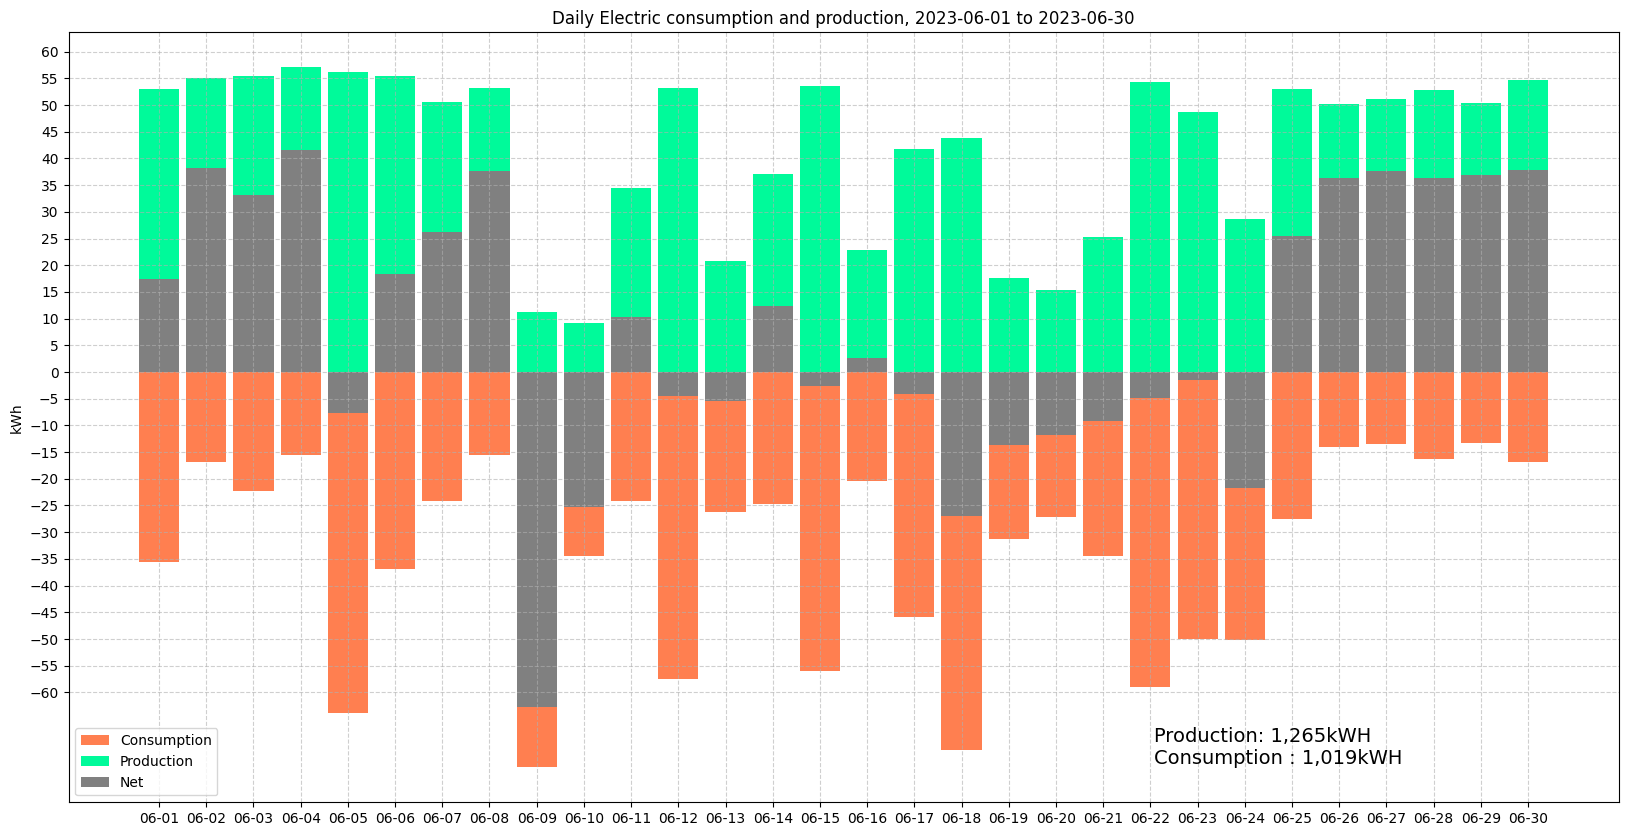

In [28]:
x = np.arange(len(daily.index))

font_size = 10

plt.rcParams.update({'font.size': font_size})
width = 0.85
fig, ax = plt.subplots(figsize = (20,10))

rects1 = ax.bar(x, -daily['consumption'], width, label='Consumption', color=CONSUMPTION_COLOR)
rects2 = ax.bar(x, daily['production'], width, label='Production', color=PRODUCTION_COLOR)
rects3 = ax.bar(x, daily['production']-daily['consumption'], width, label='Net', color=NET_COLOR)
ax.set_ylabel('kWh')
ax.set_title(f'Daily Electric consumption and production, {daily.index[0].strftime("%Y-%m-%d")} to {daily.index[-1].strftime("%Y-%m-%d")}')
ax.set_yticks(np.arange(-60,65, 5))
ax
ax.set_xticks(x, daily.index.map(lambda x: x.strftime('%m-%d')))
ax.legend()
ax.grid(alpha =.6, linestyle ='--')
ax.annotate(f"Production: {total_production:,.0f}kWH\nConsumption : {total_consumption:,.0f}kWH", (0.7, 0.05), xycoords='axes fraction', fontsize=font_size+4)


In [29]:
#
# Plot daily graphs.
# Enphase shows daily data in 15 minute intervals.
##group_by_15min = intdf.groupby(pd.Grouper(axis=0, freq='15min'))
#at15min = calculate_cumulative(group_by_15min, 3600)
#at15min

In [30]:
# Past 7 days
#daily[-7:].sum()

In [31]:

#g['production'].apply(lambda g: integrate.trapz(g, x=g.index))


In [32]:
#g.apply(lambda g: integrate.trapz(g.consumption, ))